In [1]:
import numpy as np

from utils.plot_utils import init_darkmode

init_darkmode()

## General framework for mappings, iterating mappings and visualize iteration results

A `map`, `function` or `rule` in general has a `state` defined by a set of `variables` $V$ and some properties defined by a set of `parameters` $P$. A parameter is an estimate of a given property of the system.

In [2]:
from typing import Callable
import warnings
import sys
import matplotlib.pyplot as plt

def logistic_map(p:dict, v:dict) -> dict:
    """The implementation of the map knows the compostion
    of both parameters `p['r']` and variables `v['x']`,
    and returns an output variable v_hat['x']`.
    """
    r = p['r']
    x = v['x']

    x_hat = r * x * (1 - x)

    return {'x': x_hat}

# Define the dynamics of the predator prey system
def pred_prey_map(p: dict, v: dict) -> dict:
    """The implementation of the map knows the compostion
    of both parameters `p['a', 'b', 'c', 'd', 'timestep'] and variables `v['x', 'y']` and parameters `P`,
    and returns an output variable v_hat['x', 'y']`.
    """
    
    # Parameter setup
    a = p['a']
    b = p['b']
    c = p['c']
    d = p['d']
    timestep = p['timestep']
    
    # Map the states into local variable names
    x = v['x']
    y = v['y']

    # evaluate the current differentials
    x_hat = x + (x * (a - b * y)) * timestep
    y_hat = y + (-y * (c - d * x)) * timestep

    return {'x': x_hat, 'y': y_hat}


def iterate(map: Callable, p: dict, v: dict=None, n=0) -> dict:

    if not v:
        return {}    
    else:
        trajectories = { key: [val] for key, val in v.items()}
        for _ in range(n-1):
            v_hat = map(p, v)
            for key, val in v_hat.items():
                trajectories[key].append(val)
            v = v_hat
        return trajectories


def plot_iterations(p: dict, v: dict, ax=None, figsize=(16,4), labels=False):

    if ax:
        result = ax
    else:
        result = None
        _, ax = plt.subplots(1, 1, figsize=figsize)

    if v:
        ps = '['+ (', '.join(f'{key}:{val:.4g}' for key, val in p.items()) if p else 'NA') + ']'
        v0s = '['+ (', '.join(f'{key}:{val[0]:.4g}' for key, val in v.items()) if v else 'NA') + ']'
        n_iter = max(0, max(len(val) for val in v.values()))
        ylabels=[]
        x = range(1, n_iter+1)
        for key, y in v.items():
            ax.plot(x, y, marker='.', lw=1,label=f'${key} \, | \, p={ps}, \, V_0={v0s}$')
            ylabels.append(f'${key}_t$')
        ax.set_xlabel(f'$time$ $→$')
        ax.set_ylabel(' / '.join(ylabels))
        if n_iter < 40:
            ax.set_xticks(x)

        plt.legend(loc="upper left")
        if result is None:
            plt.tight_layout()
    return result

def plot_cobweb(map, p, v, ax=None):
    """
    A cobweb plot, or Verhulst diagram is a visual tool used in the dynamical systems 
    field of mathematics to investigate the qualitative behaviour of one-dimensional 
    iterated functions, such as the logistic map. 
    
    Using a cobweb plot, it is possible to infer the long term status of an initial 
    condition under repeated application of a map.
    """

    if not ax:
            _, ax = plt.subplots(1, 1, figsize=(4, 4))
            result = None
    else:
        result = ax

    # check map is 1D, has one variable only
    # and get bounds of the maps variable
    if v and len(v.keys())==1:

        key = list(v.keys())[0]

        v_min = min(0.0, min(v[key]))
        v_max = max(1.0, max(v[key]))

        # plot mapping
        v_map = v.copy()
        v_map[key] = np.linspace(v_min, v_max)
        v_map_hat = map(p, v_map)
        ax.plot(v_map[key], v_map_hat[key], c='b', lw=2)
        ax.plot(v_map[key], v_map[key], c='b', lw=1)

        n = len(v[key])
        if n==1:
            ax.plot([v[key][0]], [v[key][0]], 'oy', ms=5)
            # ax.set_title(f'$r={r:.1f}, \, x_0={t[0]:.2g}$')
        else:
            # Recursively apply y=f(x) and plot two lines:
            # (x, x) -> (x, y)
            # (x, y) -> (y, y)
            for i in range(n-2):
                ax.plot([v[key][i], v[key][i]], [v[key][i], v[key][i+1]], c='y', lw=1)
                ax.plot([v[key][i]], [v[key][i+1]], 'oy', ms=5, alpha=(i+1)/n)
                ax.plot([v[key][i], v[key][i+1]], [v[key][i+1], v[key][i+1]], c='y', lw=1)
            ax.plot([v[key][-2], v[key][-2]], [v[key][-2], v[key][-1]], c='y', lw=1)
            ax.plot([v[key][0]], [v[key][0]], 'or', ms=5)
            c = 'g' if n>1 else 'y'
            ax.plot([v[key][-2]], [v[key][-1]], color=c, marker='o', ms=5)
            # ax.set_title(f'$r={r:.6g}, \, x_0={v[key][0]:.2g}, \, n={n}$')
            ax.set_ylabel('$x_{t+1}$')
    ax.set_xlabel('$x_{t}$')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    return result 

# Logistic map

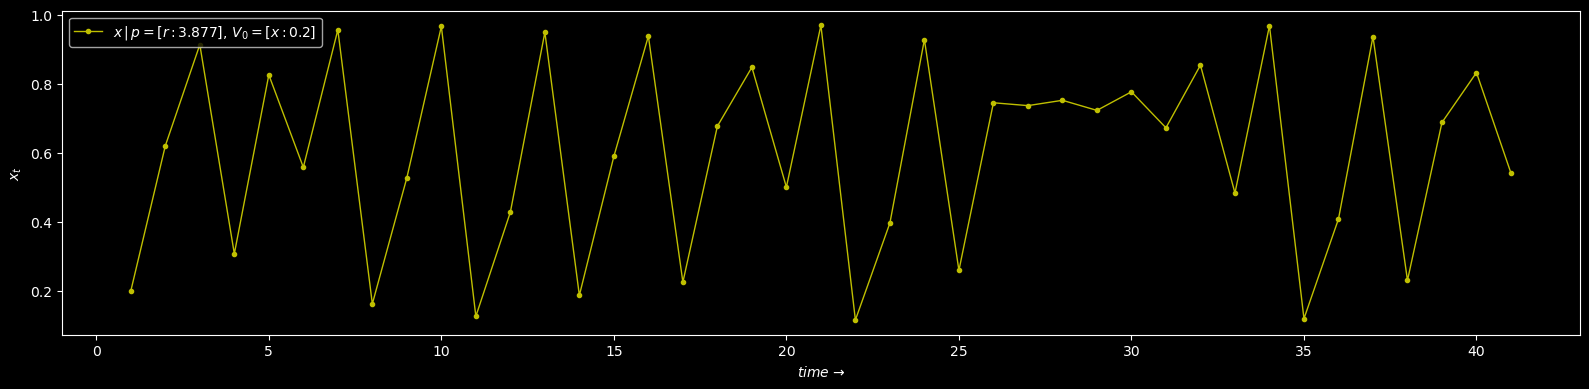

In [3]:
p={'r': 3.8768}

x0 = 0.2
v={'x':x0}

v_hat = iterate(logistic_map, p, v, n=41)
plot_iterations(p, v=v_hat)

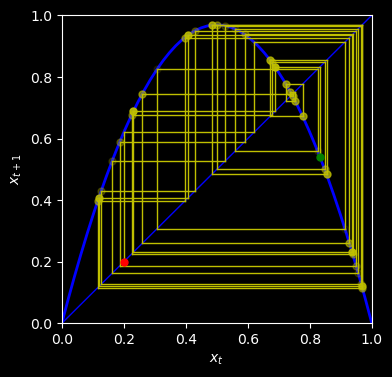

In [6]:
plot_cobweb(logistic_map, p, v_hat)

Text(0.5, 1.0, 'Phase space ($x$, $dx$)')

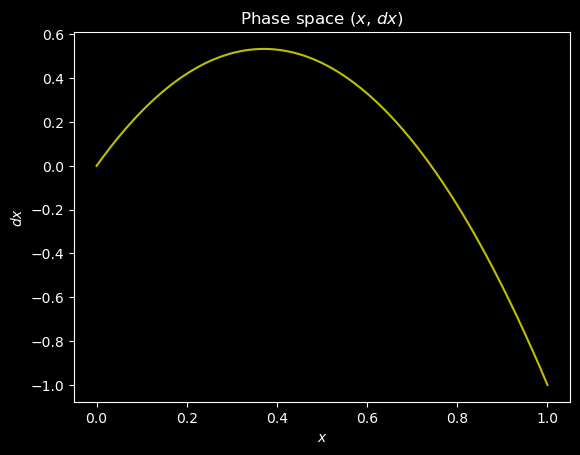

In [7]:
v={'x': np.linspace(0.0,1.0,1000)}
v_hat = logistic_map(p, v)
v_dx=v_hat['x']-v['x']

plt.plot(v['x'],v_dx)
plt.xlabel('$x$')
plt.ylabel('$dx$')
plt.title('Phase space ($x$, $dx$)')

## Predator Prey model

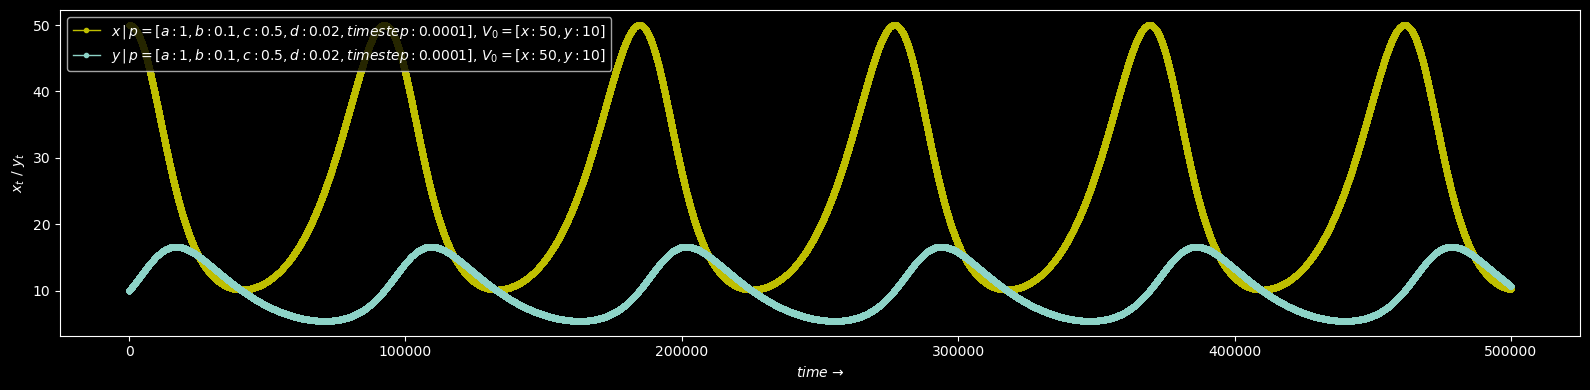

In [8]:
# initial conditions for the rabbit (x) and fox (y)
x0 = 50 # rabbits
y0 = 10 # foxes
v = {'x': x0, 'y':y0}

# definition of lotka-volterra parameters
a = 1     # birth rate of rabbits
b = 0.1   # death rate of rabbits due to predation
c = 0.5   # natural death rate of foxes
d = 0.02  # factor that describes how many eaten rabbits give birth to a new fox

timestep = 0.0001   #0.001
n = 50

p = {'a':a, 'b':b, 'c':c ,'d':d, 'timestep':timestep}


v_hat = iterate(pred_prey_map, p, v, n=int(n/timestep))

plot_iterations(p, v=v_hat)


Text(0.5, 1.0, 'Phase space ($rabbits$, $foxes$)')

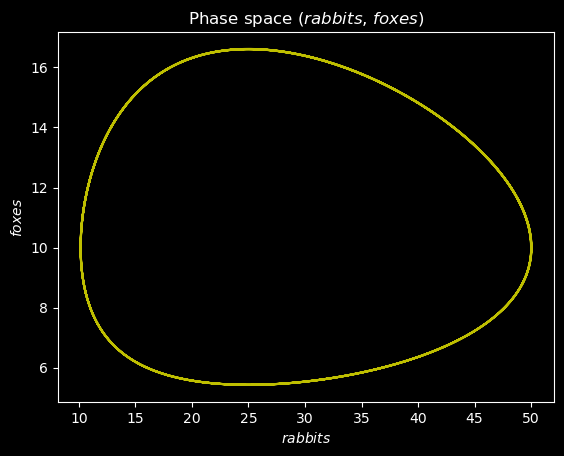

In [17]:
plt.plot(v_hat['x'],v_hat['y'])
plt.xlabel('$rabbits$')
plt.ylabel('$foxes$')
plt.title('Phase space ($rabbits$, $foxes$)')
